In [ ]:
%pip install -r PredictionModel/requirements.txt

In [ ]:
#!python PredictionModel/runPredModel.py patient-data/p001/p001.jpg
from PredictionModel.runPredModel import scanallxrays
import os
import pprint

pdir = "patient-data"
for p in os.listdir(pdir):
    patient_dir = os.path.join(pdir, p)
    print(f"patient {p}: {patient_dir}")
    pprint.pprint(scanallxrays(patient_dir))

In [ ]:
from PredictionModel.convertDcm import convertall

convertall('patient-data/p001')

Disease: Atelectasis
Setting XRayResizer engine to cv2 could increase performance.
tensor([0.1126], grad_fn=<SelectBackward0>)
Disease: Pneumonia
Setting XRayResizer engine to cv2 could increase performance.
tensor([0.0224], grad_fn=<SelectBackward0>)
Disease: Cardiomegaly
Setting XRayResizer engine to cv2 could increase performance.
tensor([0.1091], grad_fn=<SelectBackward0>)
Disease: Pleural_Thickening
Setting XRayResizer engine to cv2 could increase performance.
tensor([0.2694], grad_fn=<SelectBackward0>)


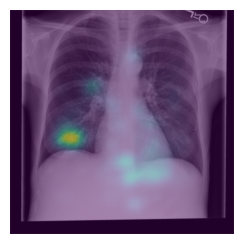

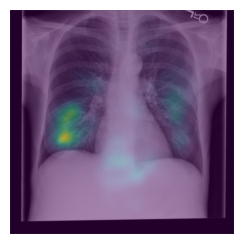

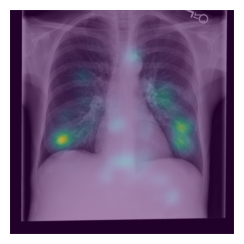

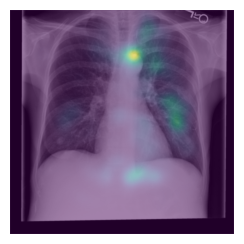

In [1]:
from PredictionModel.heatmaps import genheatmap
from PredictionModel.runPredModel import diseases


img_path = 'patient-data/p001/p001.dcm'
#pathology = 'Atelectasis'

for ds in diseases:
    print(f"Disease: {ds}")
    genheatmap(img_path, ds)

In [2]:
import torchxrayvision as xrv

model = xrv.models.get_model('densenet121-res224-all')
model.pathologies

['Atelectasis',
 'Consolidation',
 'Infiltration',
 'Pneumothorax',
 'Edema',
 'Emphysema',
 'Fibrosis',
 'Effusion',
 'Pneumonia',
 'Pleural_Thickening',
 'Cardiomegaly',
 'Nodule',
 'Mass',
 'Hernia',
 'Lung Lesion',
 'Fracture',
 'Lung Opacity',
 'Enlarged Cardiomediastinum']